# 1.1

In [20]:
%matplotlib qt
import os
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2

# Load the video and grab the first frame
reader = imageio.get_reader('ar5.gif')
first_frame = reader.get_data(0)

if os.path.exists('points_2d_initial.npy'):
    points_2d = np.load('points_2d_initial.npy')
else:
    plt.imshow(first_frame)
    plt.title("Click on corners")
    points_2d = plt.ginput(30, timeout=0) 
    plt.close()

    points_2d = np.array(points_2d)
    np.save('points_2d_initial.npy', points_2d)

points_3d = np.array([
    [0, 0, 0], [1, 0, 0], [2, 0, 0], [3, 0, 0], [4, 0, 0],
    [0, 0, 1], [1, 0, 1], [2, 0, 1], [3, 0, 1], [4, 0, 1],
    [0, 0, 2], [1, 0, 2], [2, 0, 2], [3, 0, 2], [4, 0, 2],
    [0, 1, 2], [1, 1, 2], [2, 1, 2], [3, 1, 2], [4, 1, 2],
    [0, 2, 2], [1, 2, 2], [2, 2, 2], [3, 2, 2], [4, 2, 2],
    [0, 3, 2], [1, 3, 2], [2, 3, 2], [3, 3, 2], [4, 3, 2]])
    
trackers = []
for pt in points_2d:
    tracker = cv2.legacy.TrackerMedianFlow_create()
    
    # 8x8 bounding box
    bbox = (pt[0] - 4, pt[1] - 4, 8, 8) 
    tracker.init(first_frame, bbox)
    trackers.append(tracker)

# 1.2

In [21]:
reader = imageio.get_reader('ar5.gif') 
writer = imageio.get_writer('tracking_visualization.mp4', fps=15, format='FFMPEG', mode='I')
pts2d_history = []

for frame in reader:
    vis_frame = frame.copy()
    frame_coords = []
    
    for i, tracker in enumerate(trackers):
        # Update the tracker
        success, bbox = tracker.update(frame)
        
        if success:
            x, y, w, h = [int(v) for v in bbox]
            center = (x + w//2, y + h//2)
            frame_coords.append(center)

            # Draw the green dot
            cv2.circle(vis_frame, center, 3, (0, 255, 0), -1) 
        
        else:
            frame_coords.append([None, None])
    
    pts2d_history.append(frame_coords)
    writer.append_data(vis_frame)

writer.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (190, 336) to (192, 336) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# 1.3

In [22]:
def calibrate_camera(points_3d, points_2d):
    A = []
    for i in range(len(points_3d)):
        X, Y, Z = points_3d[i]
        u, v = points_2d[i]
        
        # Skip Nones
        if u is None or np.isnan(u):
            continue
        
        # Build the homography matrix like in CS 180
        A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
        A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])
        
    A = np.array(A)
    
    # Solve Ap = 0
    _, _, Vh = np.linalg.svd(A)
    p = Vh[-1, :]
    
    # Reshape P to 3x4
    P = p.reshape(3, 4)
    return P

# 1.4

In [23]:
# Define the cube corners
cube_3d = np.array([
    [0, 0, 2, 1], [1, 0, 2, 1], [1, 1, 2, 1], [0, 1, 2, 1],
    [0, 0, 3, 1], [1, 0, 3, 1], [1, 1, 3, 1], [0, 1, 3, 1]
]).T

color_red = (0, 0, 255)
color_green = (0, 255, 0)
color_blue = (255, 0, 0)

writer = imageio.get_writer('final_ar_cube.mp4', fps=15, format='FFMPEG', mode='I')

for frame_idx, frame in enumerate(reader):
    vis_frame = frame.copy()
    P = calibrate_camera(points_3d, pts2d_history[frame_idx])
    
    # Find the projected u,v and normalize
    projected_homo = P @ cube_3d
    u_proj = projected_homo[0, :] / projected_homo[2, :]
    v_proj = projected_homo[1, :] / projected_homo[2, :]
    
    # Visualize
    # Bottom Face (Green)
    bottom_face_pts = np.array([
        [u_proj[0], v_proj[0]], 
        [u_proj[1], v_proj[1]], 
        [u_proj[2], v_proj[2]], 
        [u_proj[3], v_proj[3]]
    ], np.int32).reshape((-1, 1, 2))
    cv2.fillPoly(vis_frame, [bottom_face_pts], color_green)
    
    for start, end in [(0,1), (1,2), (2,3), (3,0)]:
        p1 = (int(u_proj[start]), int(v_proj[start]))
        p2 = (int(u_proj[end]), int(v_proj[end]))
        cv2.line(vis_frame, p1, p2, color_green, 2)

    # Top Edges (Blue)
    for start, end in [(4,5), (5,6), (6,7), (7,4)]:
        p1 = (int(u_proj[start]), int(v_proj[start]))
        p2 = (int(u_proj[end]), int(v_proj[end]))
        cv2.line(vis_frame, p1, p2, color_blue, 2)

    # Pillars (Red)
    for start, end in [(0,4), (1,5), (2,6), (3,7)]:
        p1 = (int(u_proj[start]), int(v_proj[start]))
        p2 = (int(u_proj[end]), int(v_proj[end]))
        cv2.line(vis_frame, p1, p2, color_red, 2)

    writer.append_data(vis_frame)

writer.close()
reader.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (190, 336) to (192, 336) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# 2.1
Note: the functions below are copied from my finished Colab notebook, since the assignment only requested for the 3 implemented functions and the result, I did not include the main function that generated the results in here.

In [ ]:
def affine_solve(u, v):
  # u and v: 2xN
  # returns H: 3x3

  N = u.shape[1]

  A = []
  B = []

  for i in range(N):
      # Construct A and B
      A.append([u[0, i], u[1, i], 1, 0, 0, 0])
      A.append([0, 0, 0, u[0, i], u[1, i], 1])

      B.append(v[0, i])
      B.append(v[1, i])

  A = np.array(A)
  B = np.array(B).reshape(-1, 1) # Ensure B is a column vector

  # Solve Ax = b using Normal equation
  At = A.T
  AtA = At @ A
  AtB = At @ B
  x = np.linalg.inv(AtA) @ AtB

  # Reshape the 6 parameters into the 3x3 Affine Matrix H
  H = np.array([
      [x[0, 0], x[1, 0], x[2, 0]],
      [x[3, 0], x[4, 0], x[5, 0]],
      [0,       0,       1]
  ])

  return H

def do_transform(u, H):
  # u: 2xN, H: 3x3
  # returns v: 2xN

  # Add a row of 1s for matrix multiplication
  N = u.shape[1]
  ones = np.ones((1, N))
  u = np.vstack([u, ones])

  v = H @ u

  # This is for homography, it shouldn't affect the affine transformation
  v = v[:2, :] / v[2, :]

  return v

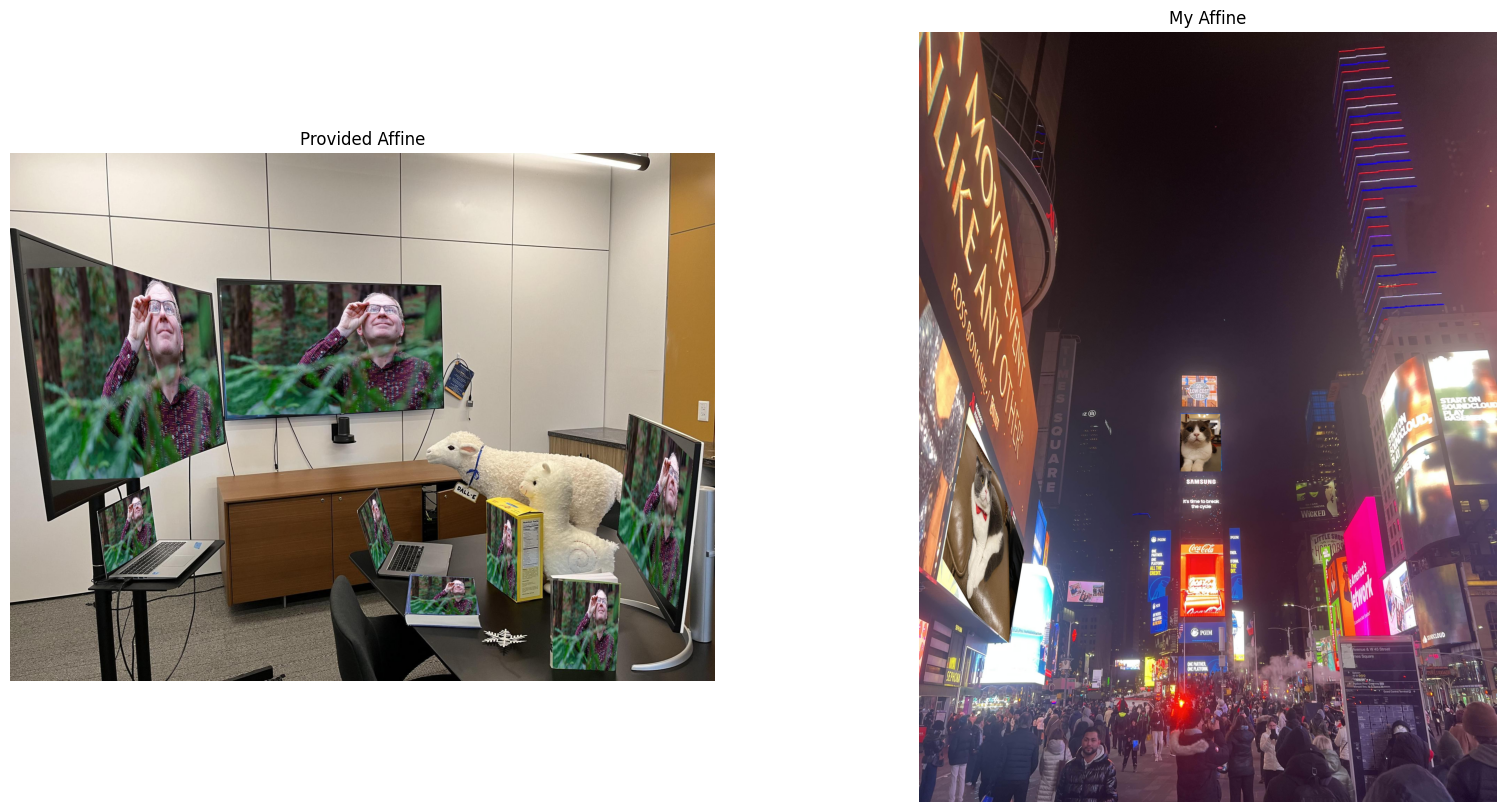

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(plt.imread('provided_affine.jpg'))
ax[0].set_title('Provided Affine')

ax[1].imshow(plt.imread('my_affine.jpg'))
ax[1].set_title('My Affine')

for a in ax:
    a.axis('off')

plt.show()

# 2.2 & 2.3

In [ ]:
def homography_solve(u,v):
  # u and v: 2xN
  # returns H: 3x3

  N = u.shape[1]
  A = []

  for i in range(N):
      x, y = u[0, i], u[1, i]
      xp, yp = v[0, i], v[1, i]
      A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
      A.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])

  A = np.array(A)

  # Solve Ah = 0 using SVD
  _, _, Vh = np.linalg.svd(A)
  h = Vh[-1, :]

  H = h.reshape((3, 3))
  H = H / H[2, 2]

  return H

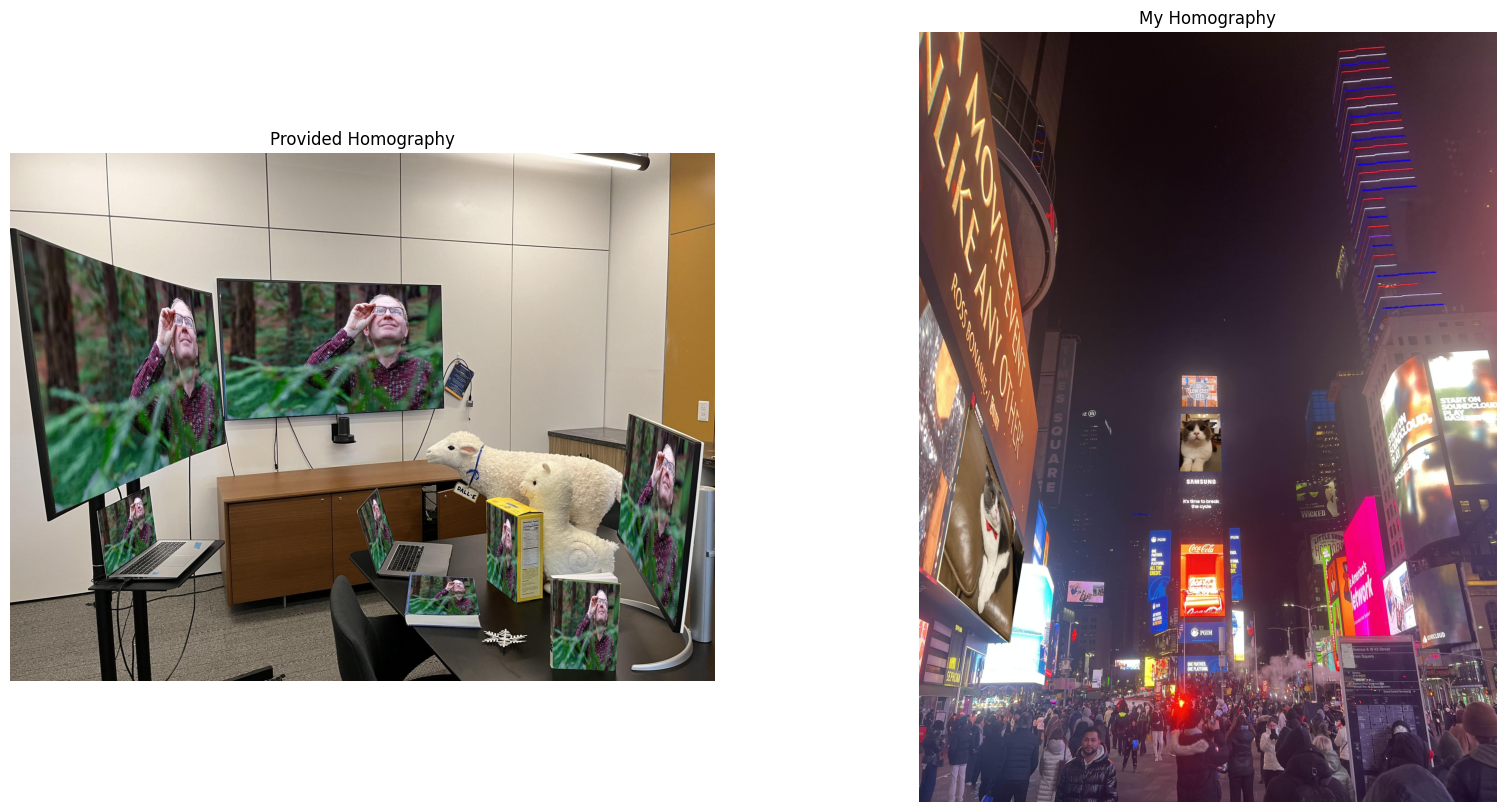

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(plt.imread('provided_homography.jpg'))
ax[0].set_title('Provided Homography')

ax[1].imshow(plt.imread('my_homography.jpg'))
ax[1].set_title('My Homography')

for a in ax:
    a.axis('off')

plt.show()

(c) What constraints are placed on H for the affine transform? How about for the homography?
(d) Is the affine transform able to exactly transform the points from one image to the other? Why or why
not?